In [611]:
# To process data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler

# To Split our data into train and test sets
from sklearn.model_selection import train_test_split

# To build our model
import tqdm as notebook_tqdm
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Metrics to evaluate our model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# To optimize our model
from scipy.optimize import minimize_scalar

import warnings
warnings.filterwarnings('ignore')

Let's upload our datasets for this analysis

In [612]:
# Let's see our items in transactions
items = pd.read_csv("./files/olist_order_items_dataset.csv")
orders = pd.read_csv("./files/olist_orders_dataset.csv")
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [613]:
# Let's evaluate the datatypes and null values
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


We don't have any null values, but some column has a datatype as an object when it is supposed to be datetime. Let's change it.

In [614]:
# Change column shipping_limit_date to a DateTime Dtype
items['shipping_limit_date'] = pd.to_datetime(items['shipping_limit_date'])
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


Great! Now let's evaluate another dataset

In [615]:
# Let's check our order data
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [616]:
# Let's see the null values and datatypes
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


We can see that some columns don't have the right datatype. Let's change them.

In [617]:
# Change object to datatime Dtype
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
orders[date_columns] = orders[date_columns].apply(pd.to_datetime)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


Perfect! Now that we have the right data types, let's evaluate our null values.

In [618]:
# Let's see our first column with null values that is oder_approved_at
orders[orders['order_approved_at'].isnull()].value_counts('order_status')

order_status
canceled     141
delivered     14
created        5
dtype: int64

As we can see most of them are canceled and created orders, so we can drop them. Created orders as well because don't have the dates yet.

In [619]:
# Remove cancel and created orders from our dataset
orders = orders[(orders['order_status'] != 'canceled') & (orders['order_status'] != 'created')]
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98811 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98811 non-null  object        
 1   customer_id                    98811 non-null  object        
 2   order_status                   98811 non-null  object        
 3   order_purchase_timestamp       98811 non-null  datetime64[ns]
 4   order_approved_at              98797 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97583 non-null  datetime64[ns]
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  98811 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.8+ MB


What about our delivered orders? Let's filter our data to evaluate this datapoint.

In [620]:
# Null rows with order_status delivered
orders[orders['order_approved_at'].isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


We can observe that it is just missing our approved date. We can take the average of other orders and fill it.

In [621]:
# Let's calculate the average of the delivered orders when the customer purchased the product and when the order when approved.
average_difference = (orders['order_approved_at'] - orders['order_purchase_timestamp']).mean()
average_difference

Timedelta('0 days 10:23:53.854246586')

Our mean is around 10 hours, so let's fill this row with this value.

In [622]:
# Fill null values in 'order_approved_at' with the calculated average difference
orders['order_approved_at'].fillna(orders['order_purchase_timestamp'] + average_difference, inplace=True)
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98811 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98811 non-null  object        
 1   customer_id                    98811 non-null  object        
 2   order_status                   98811 non-null  object        
 3   order_purchase_timestamp       98811 non-null  datetime64[ns]
 4   order_approved_at              98811 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97583 non-null  datetime64[ns]
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  98811 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.8+ MB


Great! Now we can see the other null values, let's start with order_delivered_customer_date

In [623]:
# Let's see null values from order_delivered_carrier_date
orders[orders['order_delivered_carrier_date'].isnull()].value_counts('order_status')

order_status
unavailable    609
invoiced       314
processing     301
approved         2
delivered        2
dtype: int64

In [624]:
# Let's see those who say unavailable
orders[orders['order_status'] == 'unavailable'].isnull().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     609
order_delivered_customer_date    609
order_estimated_delivery_date      0
dtype: int64

After checking the null values, we see that the two columns don't have the information we need. Let's drop these rows because it's complicated to calculate both columns.

In [625]:
# Remove rows with null values of order_delivered_carrier_date and order_delivered_customer_date
orders = orders[(orders['order_delivered_carrier_date'].notna()) & (orders['order_delivered_customer_date'].notna())]
orders.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 96469 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96469 non-null  object        
 1   customer_id                    96469 non-null  object        
 2   order_status                   96469 non-null  object        
 3   order_purchase_timestamp       96469 non-null  datetime64[ns]
 4   order_approved_at              96469 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96469 non-null  datetime64[ns]
 6   order_delivered_customer_date  96469 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96469 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB


Great! Our three datasets are ready to be analyzed.

## Exploratory Data Analysis

In [626]:
# Let's look out for the top 10 products that have been sold
items['product_id'].value_counts().head(10)

aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    488
422879e10f46682990de24d770e7f83d    484
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    388
53759a2ecddad2bb87a079a1f1519f73    373
d1c427060a0f73f6b889a5c7c61f2ac4    343
53b36df67ebb7c41585e8d54d6772e08    323
154e7e31ebfa092203795c972e5804a6    281
3dd2a17168ec895c781a9191c1e95ad7    274
Name: product_id, dtype: int64

Let's see the prices over time of our most sold product but first, we need to merge the dataset items and orders to have the purchased date.

In [627]:
# Let's merge our datasets
orders_items = pd.merge(orders, items, on='order_id')
# Let's see how many items were sold by the year
orders_items['order_purchase_year'] = orders_items['order_purchase_timestamp'].dt.year
orders_items['order_purchase_year'].value_counts()

2018    60318
2017    49553
2016      317
Name: order_purchase_year, dtype: int64

We can see that 2016 doesn't have enough data compared to other years, let's remove it and keep just the years that have more data.

In [628]:
# Remove 2016 from our dataset
orders_items = orders_items[orders_items['order_purchase_year'] != 2016]

In [629]:
# Group data by day and calculate the sum of quantity sold and mean price
daily_sales = orders_items.groupby(orders_items['order_purchase_timestamp'].dt.date).agg({'price': 'mean', 'freight_value': 'mean', 'order_item_id': 'sum'}).reset_index()
# Let's change the name of the columns order_item_id to quantity_sold and order_purchase_timestamp to date
daily_sales.rename(columns={'order_item_id': 'quantity_sold', 'order_purchase_timestamp': 'date'}, inplace=True)

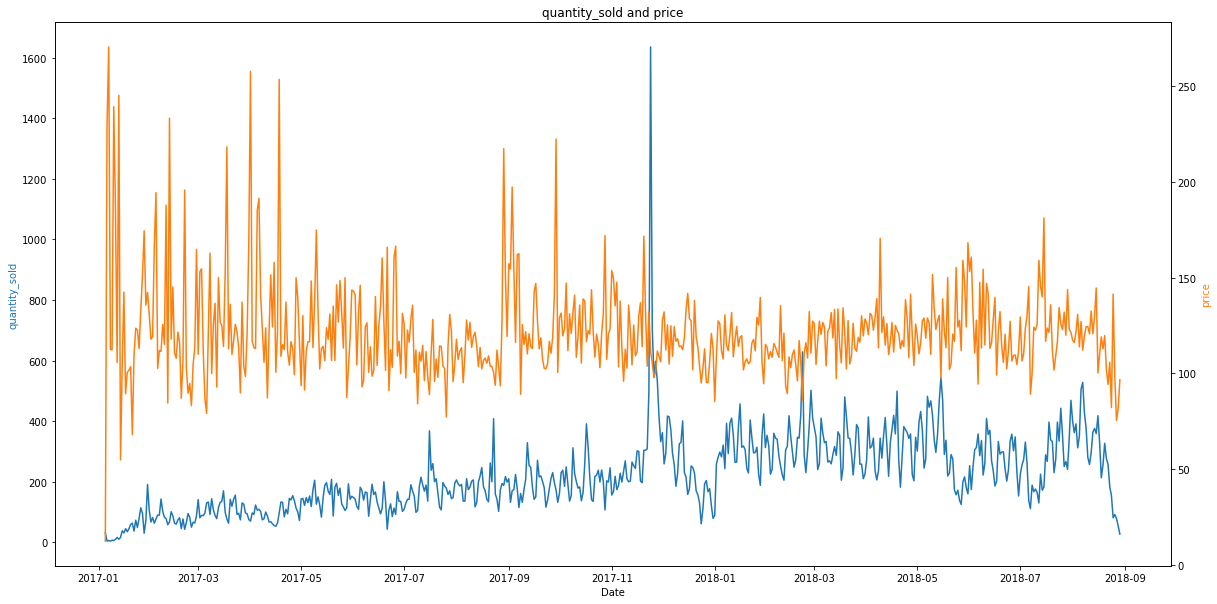

In [630]:
# Let's create a function to plot our data
# Specify the figure size (width, height) in inches
def plot_2axis(df, column_name_1, column_name_2):
    plt.figure(figsize=(20, 10))  # Adjust the size as needed

    # Create two subplots with the shared x-axis
    ax1, ax2, ax3 = plt.axes(), plt.subplot(), plt.subplot()

    # Plot quantity sold (quantity_sold) using the first y-axis (ax1)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(column_name_1, color='tab:blue')
    ax1.plot(df['date'], df[column_name_1], color='tab:blue')
    #ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis (ax2) and plot price using it
    ax2 = ax1.twinx()  # share the same x-axis
    ax2.set_ylabel(column_name_2, color='tab:orange')
    ax2.plot(df['date'], df[column_name_2], color='tab:orange')
    #ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Customize the appearance of the plot
    plt.title(f'{column_name_1} and {column_name_2}')
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

plot_2axis(daily_sales, 'quantity_sold', 'price')

We can observe that there is a correlation between the price and the quantity of orders. Seems that a considerable quantity of products are elastic. 
Also, we can observe that we have an outlier in 2017, let's look at the date and check if it has something to do with any holiday or event in Brazil.

In [631]:
# Date of the outlier
daily_sales[daily_sales['quantity_sold'] == daily_sales['quantity_sold'].max()]

,date,price,freight_value,quantity_sold
323,2017-11-24,111.462141,18.782067,1636


This date matches with Black Friday so it's ok that we have a higher volume of sales in this period.

How about price and freight value over time? Do they have any correlation?

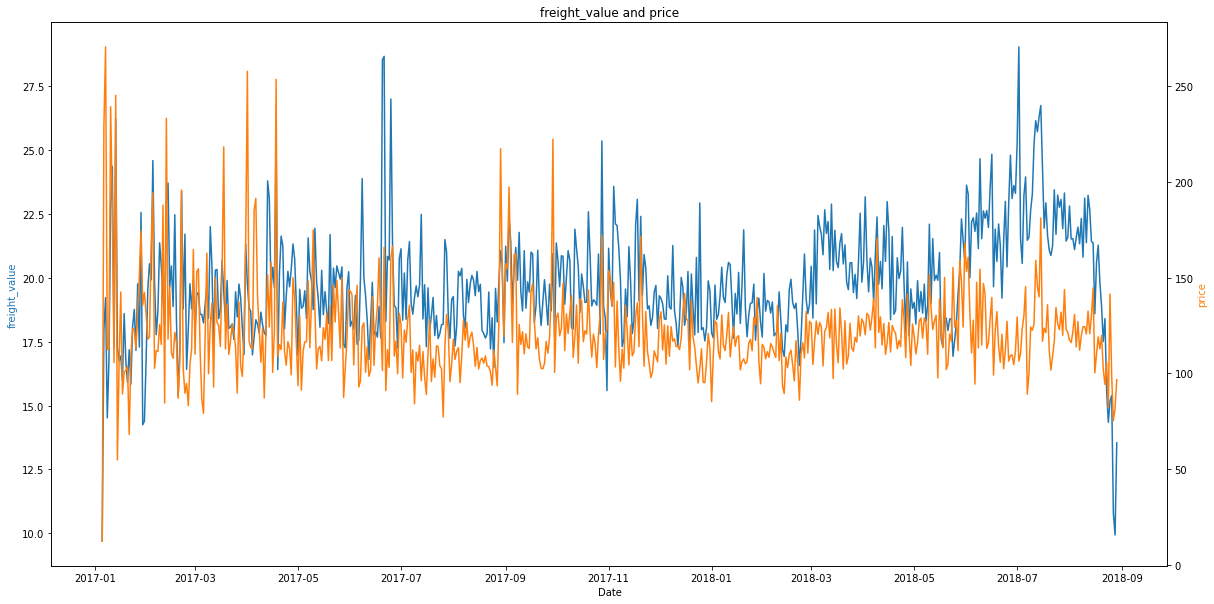

In [632]:
plot_2axis(daily_sales, 'freight_value', 'price')

We can see that the freight feature has had a bigger gap in the last few months. Why is that notorious now? Does it have something to do with some macroeconomic event?

In [633]:
# Let's upload our datasets, Let's start with the Consumer Condifex Index, Inflation rate and unemployment rate
cci = pd.read_csv("./files/cci_brazil.csv")
inflation = pd.read_csv("./files/inflation_brazil.csv")
unemployment = pd.read_csv("./files/unem_br.csv")

In [634]:
# Let's change the date format of our datasets
daily_sales['date'] = pd.to_datetime(daily_sales['date'], format='%Y-%m-%d')
cci['date'] = pd.to_datetime(cci['date'], format='%Y-%m-%d')
inflation['date'] = pd.to_datetime(inflation['date'], format='%Y-%m-%d')
#unemployment['date'] = pd.to_datetime(unemployment['date'], format='%d/%m/%y').dt.strftime('%Y-%m-%d')
unemployment['date'] = pd.to_datetime(unemployment['date'], format='%Y-%m-%d')

Let's merge our datasets to have a better understanding of the data. If our new data has an impact on sales, freight value, or price.

In [635]:
# Let's merge our three datasets with daily_sales
daily_sales = pd.merge(daily_sales, cci[['date', 'cci_value']], on='date')
daily_sales = pd.merge(daily_sales, inflation[['date', 'inflation_value']], on='date')
daily_sales = pd.merge(daily_sales, unemployment[['date', 'unemr_value']], on='date')

In [636]:
daily_sales.head()

,date,price,freight_value,quantity_sold,cci_value,inflation_value,unemr_value
0,2017-02-01,117.793281,19.530156,67,98.91882,4.758907,13.2
1,2017-03-01,109.940631,17.906036,141,99.22443,4.571105,13.7
2,2017-04-01,257.624559,19.763235,70,99.36663,4.082517,13.6
3,2017-05-01,93.546746,16.954762,143,99.42970,3.597256,13.3
4,2017-06-01,142.869259,18.096148,148,99.39207,2.998557,13.0


Great! Now that we have our data merged, let's check the correlation between our features

In [637]:
# Let's plot a correlation matrix with our features
corr = daily_sales.iloc[:, 1:-1].corr()
corr.style.background_gradient(cmap='rocket_r')

,price,freight_value,quantity_sold,cci_value,inflation_value
price,1.000000,0.228232,-0.211767,-0.179760,0.140919
freight_value,0.228232,1.000000,0.319191,0.116893,0.242310
quantity_sold,-0.211767,0.319191,1.000000,0.630159,-0.194877
cci_value,-0.179760,0.116893,0.630159,1.000000,-0.515951
inflation_value,0.140919,0.242310,-0.194877,-0.515951,1.000000


Okay, we can observe here that these macroeconomic features don't have a big impact on our prices but for our sales it does, for example, our CCI has a positive correlation with our quantity sold. To understand more the correlation, let's plot a chart and see how this positive correlation is.

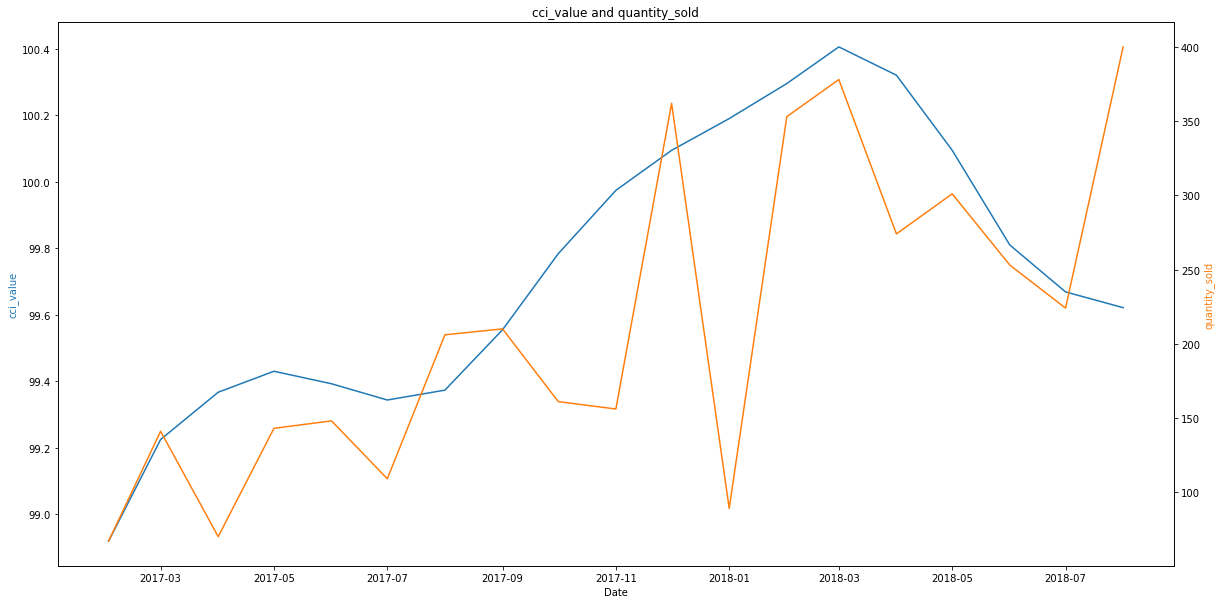

In [638]:
plot_2axis(daily_sales, 'cci_value', 'quantity_sold')

Now we observe when Consumer Index increases people tend to buy more in this e-commerce. Great, we have a feature that would help us to forecast our sales. After checking the features that we are going to use. We can think of the products that we would like to optimize.

## Products to optimize

We have so many products in the dataset but to optimize our prices, we need to select the products that have enough data. We propose those items that have been sold at least 1 product and their price points are diverse. Let's find out.

In [639]:
# Let's add the week number plus the year to our dataset so we can check the variance of the quantity sold
orders_items['week_number'] = orders_items['order_purchase_timestamp'].dt.strftime('%Y-%U')

Let's going to filter those products and count how many products we have with the conditions that we propose.

In [640]:
# Let's group the products by unique prices and sales
grouped = orders_items.groupby('product_id').agg({
    'price': pd.Series.nunique,  # Count unique prices
    'order_id': 'count'  # Count total sales (orders)
}).reset_index()

# Filter products with multiple unique prices and consistent sales
filtered_products = grouped[(grouped['price'] > 10) & (grouped['order_id'] > 0)]

# Get the list of 'product_id' for the filtered products
filtered_product_ids = filtered_products['product_id'].tolist()

# Let's count the number of filtered products
print(f"The numbers of products to optimize: {len(filtered_product_ids)}")

The numbers of products to optimize: 35


How about if we plot some charts to evaluate the performance of the filtered products over time?

In [641]:
# Let's create a function that will take a list of product, select 4 random products and plot the weekly sales
def plot_weekly_sales(product_ids_list):
    # Randomly select 4 product IDs from the list
    selected_product_ids = random.sample(product_ids_list, 4)

    # Create a subplot with 2 rows and 2 columns to plot 4 charts side by side
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Quantity sold and Price by Week for Randomly Selected Products', fontsize=16)

    # Loop through the selected product IDs and plot each one on a separate subplot
    for i, product_id in enumerate(selected_product_ids):
        row = i // 2
        col = i % 2
        ax = axes[row, col]

        # Filter the data for the current product ID
        weekly_sales = orders_items.loc[orders_items['product_id'] == product_id].groupby(['week_number', 'product_id']).agg({'order_id': 'count', 'price': 'mean'}).reset_index().sort_values(by=['week_number'])
        weekly_sales = weekly_sales.rename(columns={'order_id': 'quantity_sold'})

        # Plot quantity sold using the first y-axis (ax1)
        ax.set_xlabel('Week Number')
        ax.set_ylabel('quantity_sold', color='tab:green')
        ax.plot(weekly_sales['week_number'], weekly_sales['quantity_sold'], color='tab:green', label='Quantity Sold')

        # Create a second y-axis (ax2) and plot price using it
        ax2 = ax.twinx()  # share the same x-axis
        ax2.set_ylabel('Price', color='tab:orange')
        ax2.plot(weekly_sales['week_number'], weekly_sales['price'], color='tab:orange', label='Price')

        # Customize the appearance of the subplot
        ax.set_title(f'Product ID: {product_id}')
        #ax.grid()
        ax2.legend(loc='upper right')

    # Adjust layout and spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plots
    plt.show()

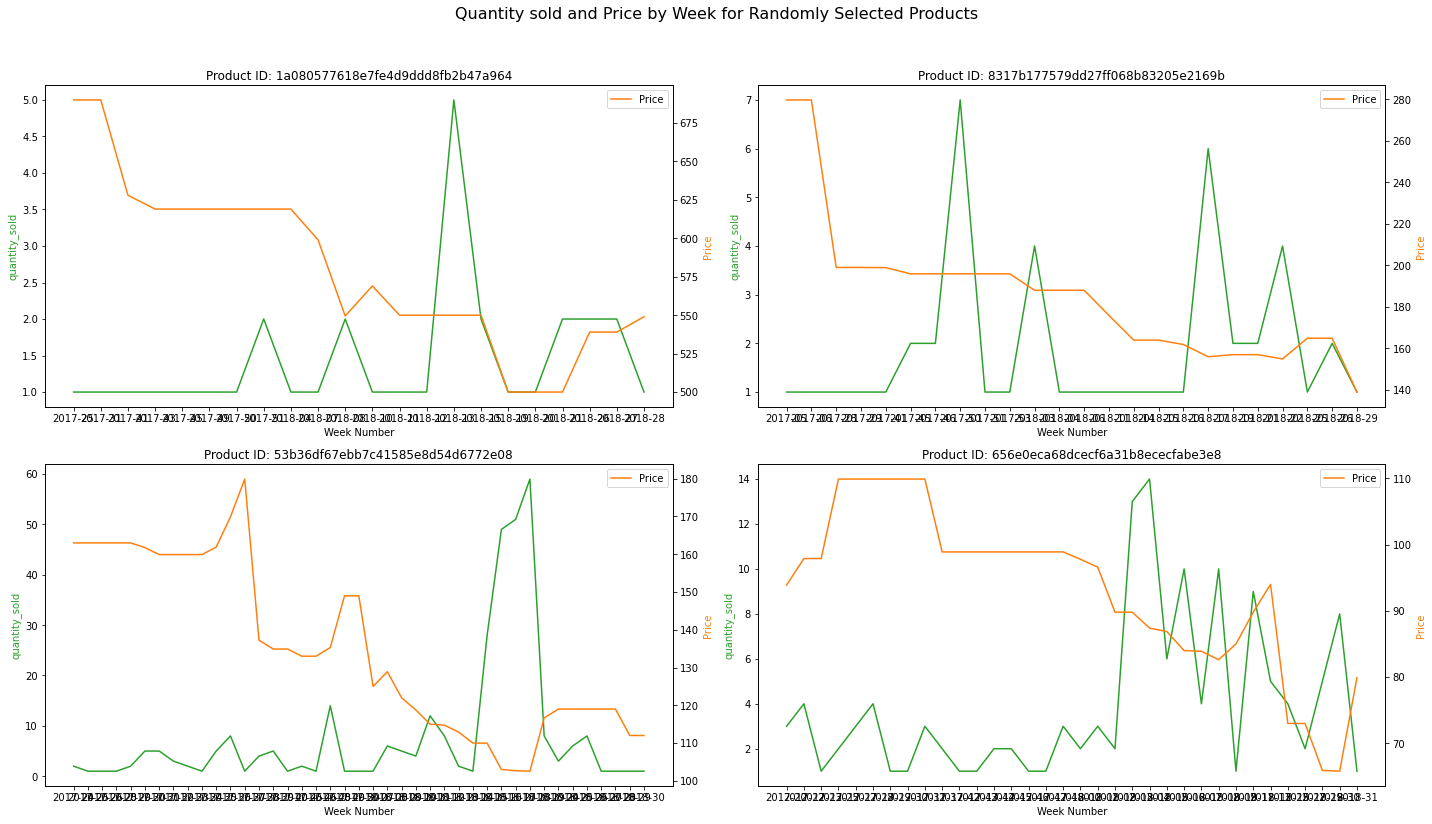

In [642]:
plot_weekly_sales(filtered_product_ids)

Now that we have the products, let's forecast demand for the next week and see if we can optimize our prices.

### Now that we have the potential products to optimize, let's find out more data about them. Let's bring the category name.

In [643]:
# Let's upload details of the products
products = pd.read_csv('./files/olist_products_dataset.csv')
# Let's merge with product_category_name_translation to have the translation from Brazil to English
en_cat = pd.read_csv('./files/product_category_name_translation.csv')
products_items = pd.merge(products, en_cat, on='product_category_name')
products_items.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,perfumaria,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,perfumaria,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


Our data is in Portuguese, let's translate it into English with another data dataset that has a relation

In [644]:
df = pd.merge(orders_items, products_items[['product_id', 'product_category_name_english']], on='product_id')
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_year,week_number,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2017,2017-40,housewares
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,2017,2017-33,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,2017,2017-31,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,2017,2017-43,housewares
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,2018,2018-29,perfumery


#### The id of the product that we are going to optimize is: 7a10781637204d8d10485c71a6108a2e. Let's see the category

In [645]:
# Let's see the category of the product mentioned before
df[df['product_id'] == '7a10781637204d8d10485c71a6108a2e'].head().value_counts('product_category_name_english')

product_category_name_english
watches_gifts    5
dtype: int64

### Now that we know that are watched. Let's find more information that can help us with the analysis

To complement our numbers we bring the trend of people looking those on internet (Google Trend) of watches in Brazil during this period, also the exchange rate between USD and BRL.

In [646]:
# Let's upload our trend dataset
trend = pd.read_csv('./files/trend.csv')
exchange_rate = pd.read_csv('./files/exchange_rate.csv')
# Let's format the date
trend['date'] = pd.to_datetime(trend['date'], format='%Y-%m-%d')
exchange_rate['date'] = pd.to_datetime(exchange_rate['date'], format='%Y-%m-%d')

In [647]:
id = orders_items.loc[orders_items['product_id'] == '7a10781637204d8d10485c71a6108a2e'].groupby(['order_purchase_timestamp', 'price', 'freight_value'])['order_id'].count().reset_index()
# Now let's change the name of the columns as date and quantity_sold
id = id.rename(columns={'order_purchase_timestamp': 'date', 'order_id': 'quantity_sold'})
# Let's add the year and moth to the dataset so we can match with our cci_values dataset
id['month'] = id['date'].dt.strftime('%Y-%m')
# let's remove the time fo the date
id['date'] = id['date'].dt.strftime('%Y-%m-%d')
# Let's change it to datetime
id['date'] = pd.to_datetime(id['date'])

Now that we have our data formatted, let's merge them

In [648]:
# Let's merge the data with exchange rate
id = pd.merge(id, exchange_rate, how='left', on='date')
# Let's merge the data with trend
id = pd.merge(id, trend, how='left', on='date')
id.head()

,date,price,freight_value,quantity_sold,month,Ex_rate,trends
0,2017-08-06,229.9,16.36,1,2017-08,NaN,NaN
1,2017-08-08,229.9,16.36,1,2017-08,3.1269,NaN
2,2017-08-10,229.9,13.11,1,2017-08,3.1757,81.0
3,2017-08-12,229.9,13.11,1,2017-08,NaN,NaN
4,2017-08-13,229.9,16.36,1,2017-08,NaN,82.0


In [649]:
# Fill NaN values using ffill and then bfill
id['Ex_rate'].fillna(method='ffill', inplace=True)
id['trends'].fillna(method='ffill', inplace=True)
id['Ex_rate'].fillna(method='bfill', inplace=True)
id['trends'].fillna(method='bfill', inplace=True)

In [650]:
# Let's add the cci_value to our id dataset but our cci dates is in monthtly format so we need to identify the month and year
cci['month'] = cci['date'].dt.strftime('%Y-%m')
unemployment['month'] = unemployment['date'].dt.strftime('%Y-%m')
inflation['month'] = inflation['date'].dt.strftime('%Y-%m')

In [651]:
# Let's merge our datasets
id = pd.merge(id, cci[['month', 'cci_value']], on='month')
id = pd.merge(id, unemployment[['month', 'unemr_value']], on='month')
id = pd.merge(id, inflation[['month', 'inflation_value']], on='month')
# Let's drop the month column
id = id.drop(columns=['month'])
# The last weeks of freight_value are 0, let's fill them with the last value
id['freight_value'] = id['freight_value'].replace(0, 15.550)
id.tail()

,date,price,freight_value,quantity_sold,Ex_rate,trends,cci_value,unemr_value,inflation_value
135,2018-05-08,199.0,15.55,1,3.5636,72.0,100.0945,12.7,2.855013
136,2018-05-09,199.0,15.55,1,3.5924,72.0,100.0945,12.7,2.855013
137,2018-05-09,199.0,15.55,1,3.5924,72.0,100.0945,12.7,2.855013
138,2018-05-09,199.0,15.55,1,3.5924,72.0,100.0945,12.7,2.855013
139,2018-05-12,199.0,15.55,1,3.5924,72.0,100.0945,12.7,2.855013


In [652]:
# Let's set the date as the index
id = id.set_index('date')
# Let's resample our data id by week but sum the quantity sold and the median of the different features
w_data = id.resample('W').agg({'quantity_sold': 'sum', 'price': 'median', 'cci_value': 'median', 'freight_value': 'median', 'unemr_value': 'median', 'inflation_value': 'median', 'trends': 'median', 'Ex_rate': 'median'}).reset_index()
# Let's fill the null values with the previous price
w_data['price'] = w_data['price'].fillna(method='ffill')
w_data['cci_value'] = w_data['cci_value'].fillna(method='ffill')
w_data['freight_value'] = w_data['freight_value'].fillna(method='ffill')
w_data['unemr_value'] = w_data['unemr_value'].fillna(method='ffill')
w_data['inflation_value'] = w_data['inflation_value'].fillna(method='ffill')
w_data['trends'] = w_data['trends'].fillna(method='ffill')
w_data['Ex_rate'] = w_data['Ex_rate'].fillna(method='ffill')
# Let's set the date as the index
w_data.head()

,date,quantity_sold,price,cci_value,freight_value,unemr_value,inflation_value,trends,Ex_rate
0,2017-08-06,1,229.9,99.37289,16.360,12.6,2.455909,81.0,3.1269
1,2017-08-13,4,229.9,99.37289,14.735,12.6,2.455909,81.0,3.1757
2,2017-08-20,0,229.9,99.37289,14.735,12.6,2.455909,81.0,3.1757
3,2017-08-27,3,229.9,99.37289,16.360,12.6,2.455909,82.0,3.1611
4,2017-09-03,2,229.9,99.55448,16.545,12.4,2.537691,82.0,3.1416


In [653]:
# Let's save our data already processed
w_data.to_csv('./files/w_data.csv')

Excellent! Now that we have our data merged, let's start with our demand forecast. For this analysis, we are going to use the time series model called Prophet from Facebook.

## Time series (Facbook Prophet)

In [654]:
# Let's create a copy of our weekly dataset
df = w_data.copy()

# Rename trend because the name 'tren' is already taken for the model
df = df.rename(columns={'trend': 'trends'})
df.head()

,date,quantity_sold,price,cci_value,freight_value,unemr_value,inflation_value,trends,Ex_rate
0,2017-08-06,1,229.9,99.37289,16.360,12.6,2.455909,81.0,3.1269
1,2017-08-13,4,229.9,99.37289,14.735,12.6,2.455909,81.0,3.1757
2,2017-08-20,0,229.9,99.37289,14.735,12.6,2.455909,81.0,3.1757
3,2017-08-27,3,229.9,99.37289,16.360,12.6,2.455909,82.0,3.1611
4,2017-09-03,2,229.9,99.55448,16.545,12.4,2.537691,82.0,3.1416


In [655]:
# Create a copy of the original DataFrame 'df' and store it in 'train'
train = df.copy()

# Convert the 'date' column in the 'train' DataFrame to datetime format
train['date'] = pd.to_datetime(train['date'])

# Create a new DataFrame 'fd' by selecting specific columns from 'train'
fd = train[['date', 'cci_value', 'freight_value', 'unemr_value', 'Ex_rate', 'trends', 'inflation_value']]

# Display the last few rows of the 'fd' DataFrame
fd.tail()

# Rename the columns in the 'train' DataFrame
train = train.rename(columns={'quantity_sold': 'y', 'date': 'ds'})

In [656]:
# Instantiate Prophet
model_new = Prophet()

# Add monthly seasonality
model_new.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Add our regressors
model_new.add_regressor('cci_value')
model_new.add_regressor('freight_value')
model_new.add_regressor('unemr_value')
model_new.add_regressor('Ex_rate')
model_new.add_regressor('trends')
model_new.add_regressor('inflation_value')

# Add our holidays from Brazil
model_new.add_country_holidays(country_name='BR')

In [657]:
# Fit the model to the training data
model_new.fit(train)

# Create a future DataFrame for 4 weeks
future_data = model_new.make_future_dataframe(periods=4, freq = 'W')

15:52:34 - cmdstanpy - INFO - Chain [1] start processing
15:52:34 - cmdstanpy - INFO - Chain [1] done processing


In [658]:
# Let's see our future data
future_data['ds'] = future_data['ds'].dt.strftime('%Y-%m-%d')
future_data.tail()

,ds
40,2018-05-13
41,2018-05-20
42,2018-05-27
43,2018-06-03
44,2018-06-10


In [659]:
# Let's merge our future data with our features
combined_df = pd.concat([fd, future_data], axis=1)
combined_df = combined_df[['ds', 'cci_value', 'freight_value', 'unemr_value', 'Ex_rate', 'trends', 'inflation_value']]

# Fill NaN values in the 'Value' column with the last valid value
combined_df['cci_value'].fillna(method='ffill', inplace=True)
combined_df['freight_value'].fillna(method='ffill', inplace=True)
combined_df['unemr_value'].fillna(method='ffill', inplace=True)
combined_df['Ex_rate'].fillna(method='ffill', inplace=True)
combined_df['trends'].fillna(method='ffill', inplace=True)
combined_df['inflation_value'].fillna(method='ffill', inplace=True)

# Let's see our combined data
combined_df.tail()

,ds,cci_value,freight_value,unemr_value,Ex_rate,trends,inflation_value
40,2018-05-13,100.0945,15.55,12.7,3.5636,72.0,2.855013
41,2018-05-20,100.0945,15.55,12.7,3.5636,72.0,2.855013
42,2018-05-27,100.0945,15.55,12.7,3.5636,72.0,2.855013
43,2018-06-03,100.0945,15.55,12.7,3.5636,72.0,2.855013
44,2018-06-10,100.0945,15.55,12.7,3.5636,72.0,2.855013


In [660]:
# Predict on the 'future' dataset
forecast_data = model_new.predict(combined_df)

# Display the first few rows of the resulting DataFrame 'forecast_data'
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
40,2018-05-13,8.777564,6.695799,10.770377
41,2018-05-20,9.379716,7.169249,11.403958
42,2018-05-27,13.170325,10.923229,15.024032
43,2018-06-03,10.794044,8.847263,12.801958
44,2018-06-10,8.341331,6.367506,10.265719


What about if we check how are model performed with a chart?

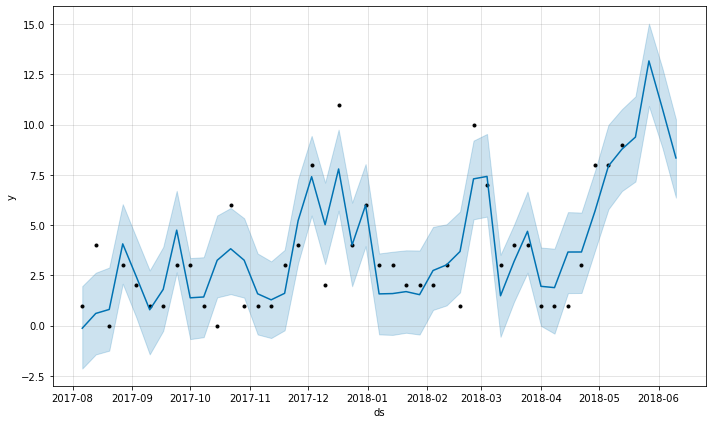

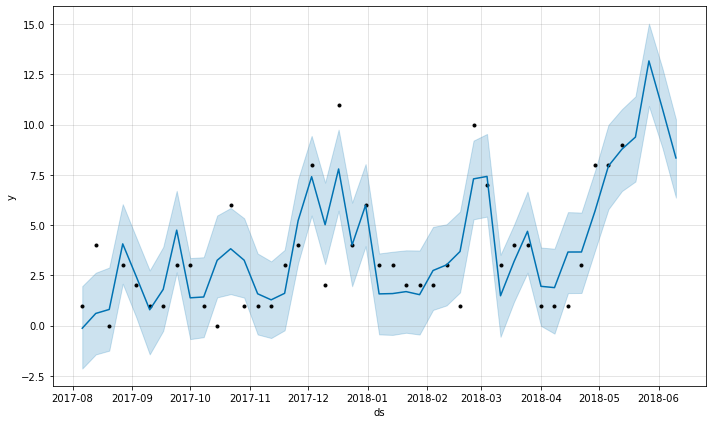

In [661]:
# Let's plot the forecast
model_new.plot(forecast_data)

Great! Let's evaluate the performance of our model with the metrics.

In [662]:
performance = pd.merge(train, forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
print(f'Performance MAE: {performance_MAE}')

Performance MAE: 1.2340877773888004


In [663]:
# Now let's take out the last 4 weeks of our forecast
forecast_data_4w = forecast_data.iloc[-4:, :]
forecast_data_4w = forecast_data_4w[['ds', 'yhat_lower', 'yhat_upper']]

# Let's rename to lower quantity and upper quantity
forecast_data_4w = forecast_data_4w.rename(columns={'yhat_lower': 'lower_quantity', 'yhat_upper': 'upper_quantity'})
# Let's also lower round the values
forecast_data_4w['lower_quantity'] = forecast_data_4w['lower_quantity'].apply(np.floor).astype(int)
forecast_data_4w['upper_quantity'] = forecast_data_4w['upper_quantity'].apply(np.floor).astype(int)

forecast_data_4w

,ds,lower_quantity,upper_quantity
41,2018-05-20,7,11
42,2018-05-27,10,15
43,2018-06-03,8,12
44,2018-06-10,6,10


Now that we have our demand forecast for the next 4 weeks. We can work on our price optimization. Let's start to predict our prices for each point of our demand forecast. For this analysis, we are going to use the linear regression model.

## Linear regression

In [664]:
# Let's add the month, weekly, and year seasonality to our dataset
w_data['month'] = w_data['date'].dt.month
w_data['week'] = w_data['date'].dt.isocalendar().week

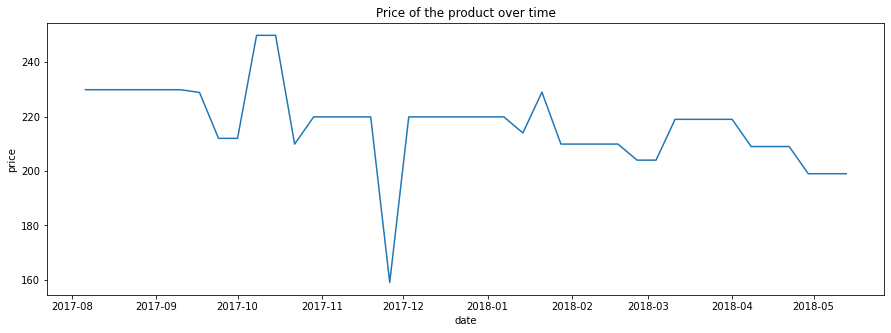

In [665]:
# How about if before start the model, let's plot a chart to see all the prices that have been recorded
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=w_data, x='date', y='price', ax=ax)
plt.title('Price of the product over time')
plt.show()

We have a price point very unusual, which is close to Black Friday. Let's filter if this drop has a relation with this event. Also, there are price points higher than usual. Let's check both.

In [666]:
# Outliers
w_data.loc[w_data['price'] < 180]

,date,quantity_sold,price,cci_value,freight_value,unemr_value,inflation_value,trends,Ex_rate,month,week
16,2017-11-26,4,159.0,99.97388,18.39,12.0,2.803785,71.0,3.2219,11,47


In [667]:
# Higher than 220
w_data.loc[w_data['price'] > 220]

,date,quantity_sold,price,cci_value,freight_value,unemr_value,inflation_value,trends,Ex_rate,month,week
0,2017-08-06,1,229.9,99.37289,16.360,12.6,2.455909,81.0,3.1269,8,31
1,2017-08-13,4,229.9,99.37289,14.735,12.6,2.455909,81.0,3.1757,8,32
2,2017-08-20,0,229.9,99.37289,14.735,12.6,2.455909,81.0,3.1757,8,33
3,2017-08-27,3,229.9,99.37289,16.360,12.6,2.455909,82.0,3.1611,8,34
4,2017-09-03,2,229.9,99.55448,16.545,12.4,2.537691,82.0,3.1416,9,35
5,2017-09-10,1,229.9,99.55448,13.110,12.4,2.537691,82.0,3.1174,9,36
6,2017-09-17,1,228.9,99.55448,13.100,12.4,2.537691,80.0,3.1174,9,37
9,2017-10-08,1,249.9,99.78332,19.000,12.2,2.701321,80.0,3.1544,10,40
10,2017-10-15,0,249.9,99.78332,19.000,12.2,2.701321,80.0,3.1544,10,41
24,2018-01-21,2,229.0,100.18980,22.310,12.2,2.855116,45.0,3.2243,1,3


We can observe that we just have two price points with 249.9 and one of them didn't have sales. To avoid any bias, let's remove this price point.

Yes, this drop has a relation with Black Friday. Let's remove this point so our model can't be biased.

In [668]:
# Removing the outliers
w_data = w_data.drop(w_data[w_data['price'] == 159].index)
w_data = w_data.drop(w_data[w_data['price'] > 240].index)

Great! Now that we have our prices okay, let's select our features and train our model.

In [669]:
# Select specific columns from the 'w_data' DataFrame to create the feature matrix 'X'
X = w_data[['quantity_sold', 'cci_value', 'freight_value', 'month', 'unemr_value']]

# Select the target variable 'price' and create the target vector 'y'
y = w_data[['price']]

# Create an instance of StandardScaler, which will be used to standardize (scale) the features
scaler = StandardScaler()

# Standardize the feature matrix 'X' using the StandardScaler
X = scaler.fit_transform(X)

# The 'test_size' parameter specifies that 15% of the data will be used for testing, and 'random_state' sets a seed for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

Now it is time to train our model and evaluate their performance. We are going to test: Gradient boosting, Random Forest, and XGBoost.

### Gradient boosting regressor

In [670]:
# Let's train our model
model = GradientBoostingRegressor()

# Let's train our model
model.fit(X_train,y_train)

# Let's predict the price
y_pred = model.predict(X_test)

# Let's calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
# Let's calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
# Let's calculate the r2 score
r2 = r2_score(y_test, y_pred)

# Let's print the results
print('MSE: ', mse)
print('MAE: ', mae)
print('R2: ', r2)

MSE:  11.032681934458134
MAE:  2.3925488738259495
R2:  0.8998414946890433


In [671]:
# Let's train our model
model_X = XGBRegressor()

# Let's train our model
model_X.fit(X_train,y_train)

# Let's predict the price
y_pred_X = model_X.predict(X_test)

# Let's calculate the mean squared error
mse_X = mean_squared_error(y_test, y_pred_X)
# Let's calculate the mean absolute error
mae_X = mean_absolute_error(y_test, y_pred_X)
# Let's calculate the r2 score
r2_X = r2_score(y_test, y_pred_X)

# Let's print the results
print('MSE: ', mse_X)
print('MAE: ', mae_X)
print('R2: ', r2_X)

MSE:  2.3979404600771765
MAE:  1.1094004313151042
R2:  0.978230666511298


In [672]:
# Let's train our model
model_R = RandomForestRegressor()

# Let's train our model
model_R.fit(X_train,y_train)

# Let's predict the price
y_pred_R = model_R.predict(X_test)

# Let's calculate the mean squared error
mse_R = mean_squared_error(y_test, y_pred_R)
# Let's calculate the mean absolute error
mae_R = mean_absolute_error(y_test, y_pred_R)
# Let's calculate the r2 score
r2_R = r2_score(y_test, y_pred_R)

# Let's print the results
print('MSE: ', mse_R)
print('MAE: ', mae_R)
print('R2: ', r2_R)

MSE:  17.097144499999626
MAE:  2.942833333333278
R2:  0.8447862044443583


In [673]:
# Let's create a dataframe with the results
results = pd.DataFrame({'Regression Model': ['Gradient Boosting', 'XGBoost', 'Random Forest'],
                        'MSE': [mse, mse_X, mse_R],
                        'MAE': [mae, mae_X, mae_R],
                        'R2': [r2, r2_X, r2_R]}).sort_values(by='R2', ascending=False).reset_index(drop=True)

results

,Regression Model,MSE,MAE,R2
0,XGBoost,2.397940,1.109400,0.978231
1,Gradient Boosting,11.032682,2.392549,0.899841
2,Random Forest,17.097144,2.942833,0.844786


Now that we have the best model performance let's use the best one to predict the prices of our product. 

In [674]:
# Let's create a function to make predictions
def predict_price(quantity_sold, cci_value, freight_value, month, unemr_value):
    price = model_X.predict(scaler.transform([[quantity_sold, cci_value, freight_value, month, unemr_value]]))
    print(f'Predicted price: {price[0]}')

To predict the prices for the next week, we need to predict the prices for each point of our demand forecast. Let's do it.

But our regressor model has more than quantity features. We have Customer Index, Unemployment rate and Freight value. Foe this analysis, we are going to use the last one that the goverment publish. As a usual practice, we use the last data available.

In [675]:
# Let's set our variables
cci_value = 100.0945
freight_value = 15.55
unemr_value = 12.7
# Month 5 is May
month = 5
# Let's bring the lower and upper bounds of the quantity sold of forecast_data_4w
lower_bound = forecast_data_4w['lower_quantity'].iloc[0]
upper_bound = forecast_data_4w['upper_quantity'].iloc[0]

In [700]:
prices = []
quantity_sold = []

# Now let's iterate through the list make predictions and then store them in a list
for i in range(lower_bound, upper_bound + 1):
    quantity_sold.append(i)
    price = model_X.predict(scaler.transform([[i, cci_value, freight_value, month, unemr_value]]))
    prices.append(price[0])

# Let's create a dataframe with the results
results = pd.DataFrame({'quantity_sold': quantity_sold,
                        'price': prices})

# Now that we have the prices and quantity sold, let's calculate our profit by subtracting the freight value from our price and then multiplying by the quantity sold
results['profit'] = (results['price'] - freight_value) * results['quantity_sold']

# Let's see our results for the different prices
results

,quantity_sold,price,profit
0,7,199.420792,1287.095520
1,8,199.379089,1470.632690
2,9,198.999908,1651.049149
3,10,199.472931,1839.229279
4,11,199.472931,2023.152206


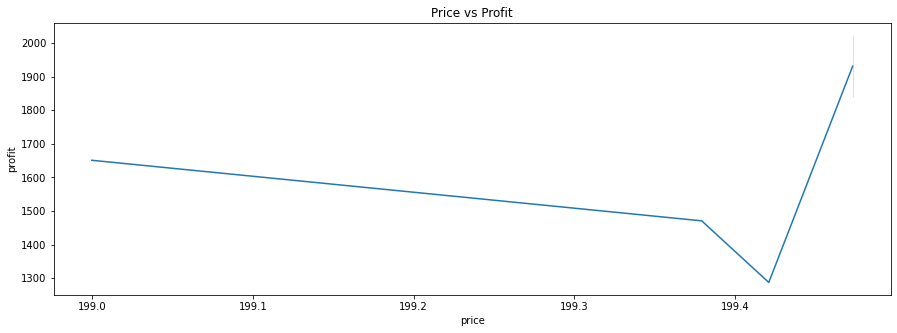

In [701]:
# Let's plot the curve between prices and their profit
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=results, x='price', y='profit', ax=ax)
plt.title('Price vs Profit')
plt.show()

Now that we have the prices for different quanitties, let's evaluate what is the optimal price to maximize our profit.

# Price Optimization

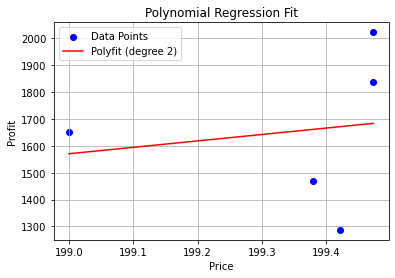

In [703]:
# Your price and profit data
prices = np.array(results['price'])
profits = np.array(results['profit'])

# Fit a polynomial regression model (in this case, let's use a polynomial of degree 2)
degree = 2
coefficients = np.polyfit(prices, profits, degree)

# Create the polynomial fit function
polyfit_func = np.poly1d(coefficients)

# Generate a range of x values for the plot
x_values = np.linspace(min(prices), max(prices), 100)

# Calculate corresponding y values using the polynomial fit function
y_values = polyfit_func(x_values)

# Create a scatterplot of the data
plt.scatter(prices, profits, label='Data Points', color='b', marker='o')

# Plot the polynomial fit curve
plt.plot(x_values, y_values, label=f'Polyfit (degree {degree})', color='r')

plt.title('Polynomial Regression Fit')
plt.xlabel('Price')
plt.ylabel('Profit')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Let's plot the function

In [704]:
# Create the polynomial fit function
polyfit_func = np.poly1d(coefficients)

# Print the polynomial function
print("Polynomial Fit Function:")
print(polyfit_func)

Polynomial Fit Function:
        2
0.5927 x + 2.813 x - 2.246e+04


### Let's use the function to optimize our prices

In [705]:
# Define the profit function based on your new polynomial function
def profit(price):
    # Define your new polynomial function coefficients
    coefficients = [0.5927, 2.813, -2.246e+04]
    return -(coefficients[0] * price**2 + coefficients[1] * price + coefficients[2])

# Define the price constraints
price_bounds = (price.min(), price.max())

# Use minimize_scalar to find the maximum profit
result = minimize_scalar(profit, bounds=price_bounds, method='bounded')

# Extract the optimized price and maximized profit
optimized_price = result.x
maximized_profit = -result.fun  # Convert back to positive

# Print the results
print(f"Optimal Price: ${optimized_price:.2f}")
print(f"Maximized Profit: ${maximized_profit:.2f}")

Optimal Price: $199.47
Maximized Profit: $1684.32
